# Fatal Car Accident Clusters on Montana Indian Reservations

DSAN 6750 / PPOL 6805: GIS for Spatial Data Science

Gentry Lamb (Georgetown University)

## Introduction

> In the United States, the American Indian and Alaska Native (AI/AN) population has the highest motor vehicle death rate, which is significantly greater than that of any other race or ethnic group. ([Pollack et al. 2012](#ref-pollack_motor_2012))

Traffic fatalities are a critical public safety concern, and understanding their spatial patterns is essential for devising targeted interventions. In Montana, a state characterized by vast rural landscapes and a significant Native American population, reservations play a crucial role in the socio-cultural and geographic fabric. Despite making up only a fraction of the state’s total area, reservations are home to unique road networks and distinct socio-economic conditions, which may influence traffic safety outcomes.

Research on traffic fatalities has often revealed that crashes do not occur randomly across space but instead exhibit spatial patterns due to underlying factors such as road design, traffic density, and environmental conditions. In particular, reservations may face unique challenges, including limited road maintenance resources, longer emergency response times, and differing traffic laws, all of which could contribute to fatal crash clustering. However, the extent to which these crashes exhibit significant spatial clustering on reservations compared to other areas remains unclear.

This study seeks to address this gap by examining whether fatal car crashes on Montana Reservations show significant spatial clustering relative to crashes occurring outside reservation boundaries. Using GIS and spatial data science tools, the study will analyze crash locations to test the hypothesis:

> **Fatal car crashes on Montana Reservations show significant spatial clustering compared to crashes outside reservation areas.**

Through this analysis, the study aims to identify potential spatial patterns and their implications for road safety planning and resource allocation, contributing to a deeper understanding of traffic fatalities in culturally and geographically distinct areas like Montana Reservations.

## Literature Review

## Methodology

### Data

Our data is sourced from several places. The first comes from the Montana Spatial Data Infrastructure ([Library 2021](#ref-msdi_tribal_nations_2021)), which provided the shape files for the 7 different Montana Reservations. The fatal car accident data was sourced from the National Highway Traffic Safety Administration’s Fatality Analysis Reporting System ([Administration 2020-2022](#ref-nhtsa_FARS_2020_2022)). It provided location data and many other attributes for all fatal car accidents across the nation.

### Statistical Test

Moran’s I: Calculate the global Moran’s I statistic to determine the degree of spatial autocorrelation within and outside reservation areas.

## Exploratory Data Analysis (EDA)

In [ ]:
library(dplyr) |> suppressPackageStartupMessages()
library(sf) |> suppressPackageStartupMessages()
library(spatstat) |> suppressPackageStartupMessages()
library(stars) |> suppressPackageStartupMessages()
library(mapview) |> suppressPackageStartupMessages()
library(units) |> suppressPackageStartupMessages()
library(ggplot2) |> suppressPackageStartupMessages()
cb_palette <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
set.seed(6750)
raster_eps <- 500

In [ ]:
# read in the state and reservation shape files, only keeping name and geometry
mt_sf <- sf::read_sf("data/MontanaStateBoundary_shp/StateofMontana.shp")  |> select(NAME, geometry) |> st_transform(3857)
rez_sf <- sf::read_sf("data/MontanaReservations_shp/MontanaReservations.shp") |> select(NAME, geometry) |> st_transform(3857)
head(rez_sf)

Show Montana as a whole with the reservations overlayed

In [ ]:
# create mnapview objects of the state and reservations
mt_map <- mapview(mt_sf)
rez_map <- mapview(rez_sf, label='NAME')
# display
# mt_map + rez_map

In [ ]:
# read in fatal accident data from each year, only keeping relevant columns
df20 <- read.csv('./data/accident2020.csv') |> filter(STATENAME=='Montana') |> select(STATENAME, FATALS, LATITUDE, LONGITUD) |> mutate(YEAR=2020)
df21 <- read.csv('./data/accident2021.csv') |> filter(STATENAME=='Montana') |> select(STATENAME, FATALS, LATITUDE, LONGITUD) |> mutate(YEAR=2021)
df22 <- read.csv('./data/accident2022.csv') |> filter(STATENAME=='Montana') |> select(STATENAME, FATALS, LATITUDE, LONGITUD) |> mutate(YEAR=2022)
# combine all years into one year
accidents_df <- rbind(df20, df21, df22)
head(accidents_df)

Now we plot the fatal car accidents that occured in Montana in the years 2020-2022.

In [ ]:
# prepare accidents sf and show map
accidents_sf<- sf::st_as_sf(
    accidents_df,
    coords = c("LONGITUD", "LATITUDE"), 
    crs = 4326
  )
# create map boject of accidents
accidents_map <- mapview(accidents_sf)

Warning in sf::st_is_longlat(x): bounding box has potentially an invalid value
range for longlat data

Now let’s use `sf_join` to see which accidents occur within the bounds of a reservation and plot them again. This time we include the convex hull of Montana.

In [ ]:
# get MT convex hull
mt_hull_sf <- mt_sf |> sf::st_convex_hull()
# create map object
mt_hull_map <- mapview(mt_hull_sf)

# add new column that indicates if the crash occured on a reservation
accidents_sf <- accidents_sf |> st_transform(3857) 
accidents_sf <- st_join(accidents_sf, rez_sf) |> mutate(
    reservation = (!is.na(NAME))
)
# create map object of accidents
accidents_rez_map <- mapview(accidents_sf, zcol='reservation')

Warning in validateCoords(lng, lat, funcName): Data contains 2 rows with either
missing or invalid lat/lon values and will be ignored

## Hypothesis Testing (Regression)

Make non-reservation car accidents a `ppp` object.

Warning in spatstat.geom::ppp(cc[, 1], cc[, 2], window = W, marks = NULL, : 2
out of 501 points had NA or NaN coordinate values, and were discarded

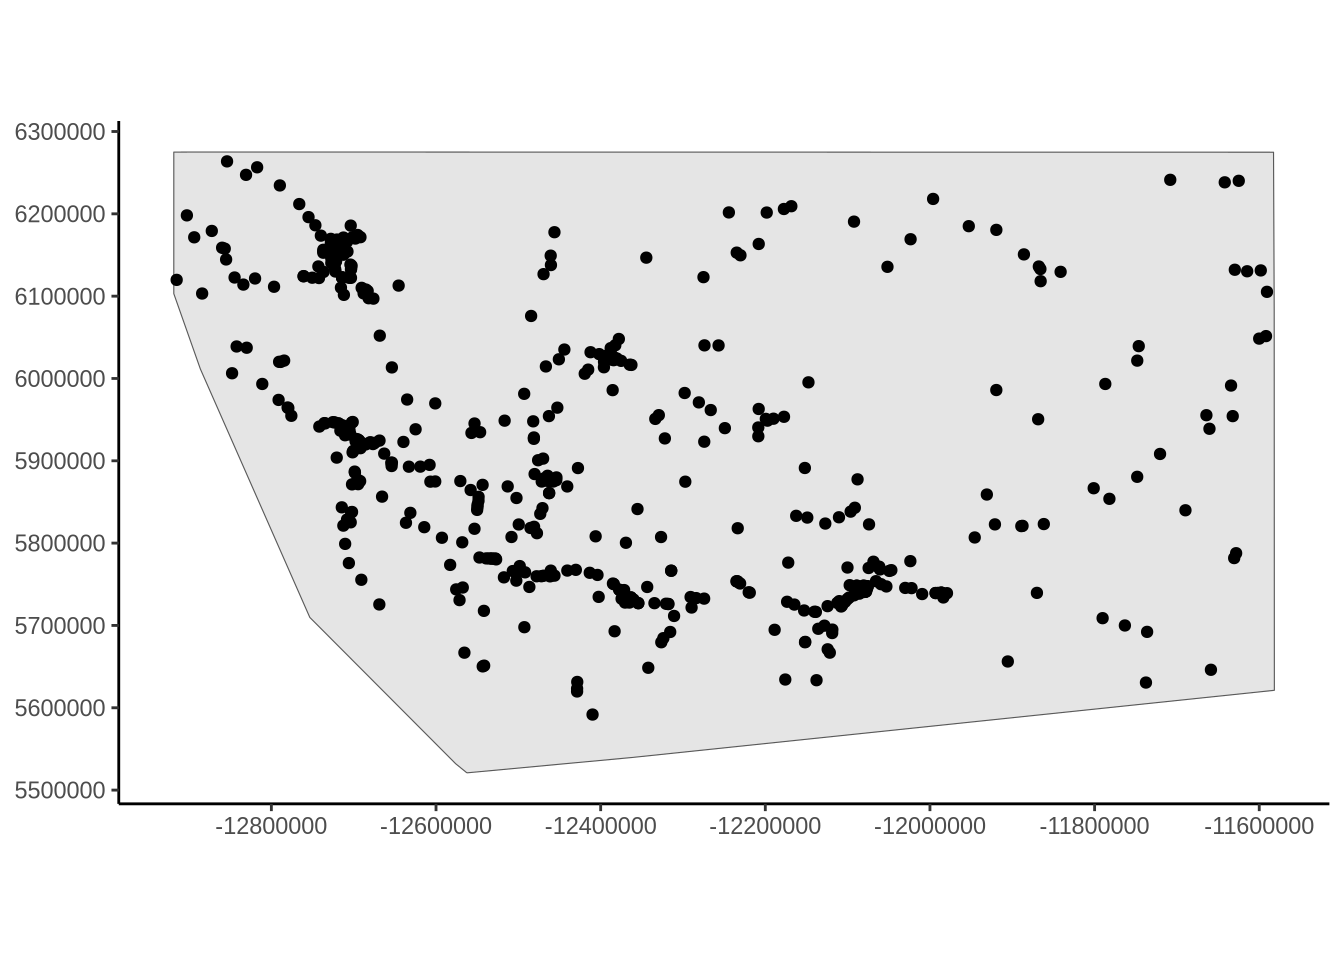

In [ ]:
accidents_non_sfc <- accidents_sf |> filter(reservation==FALSE) |> sf::st_as_sfc()
accidents_non_ppp <- as.ppp(accidents_non_sfc, W=as.owin(mt_hull_sf))

Estimating the Population Intensity Function

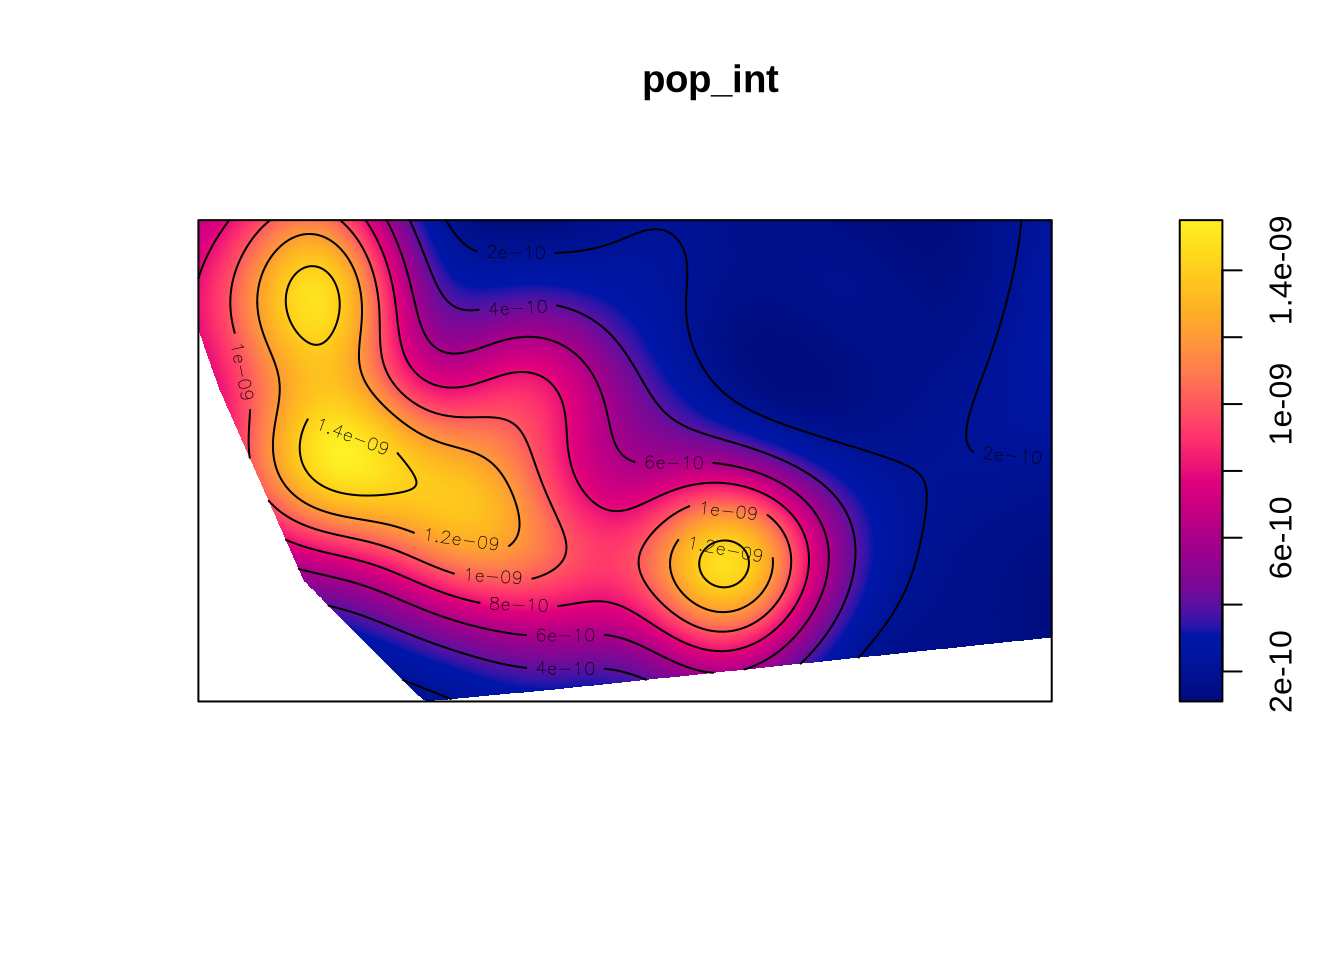

In [ ]:
pop_int <- density(accidents_non_ppp, eps=raster_eps)

plot(pop_int)
contour(pop_int, add=TRUE)

ppp intensity overlay

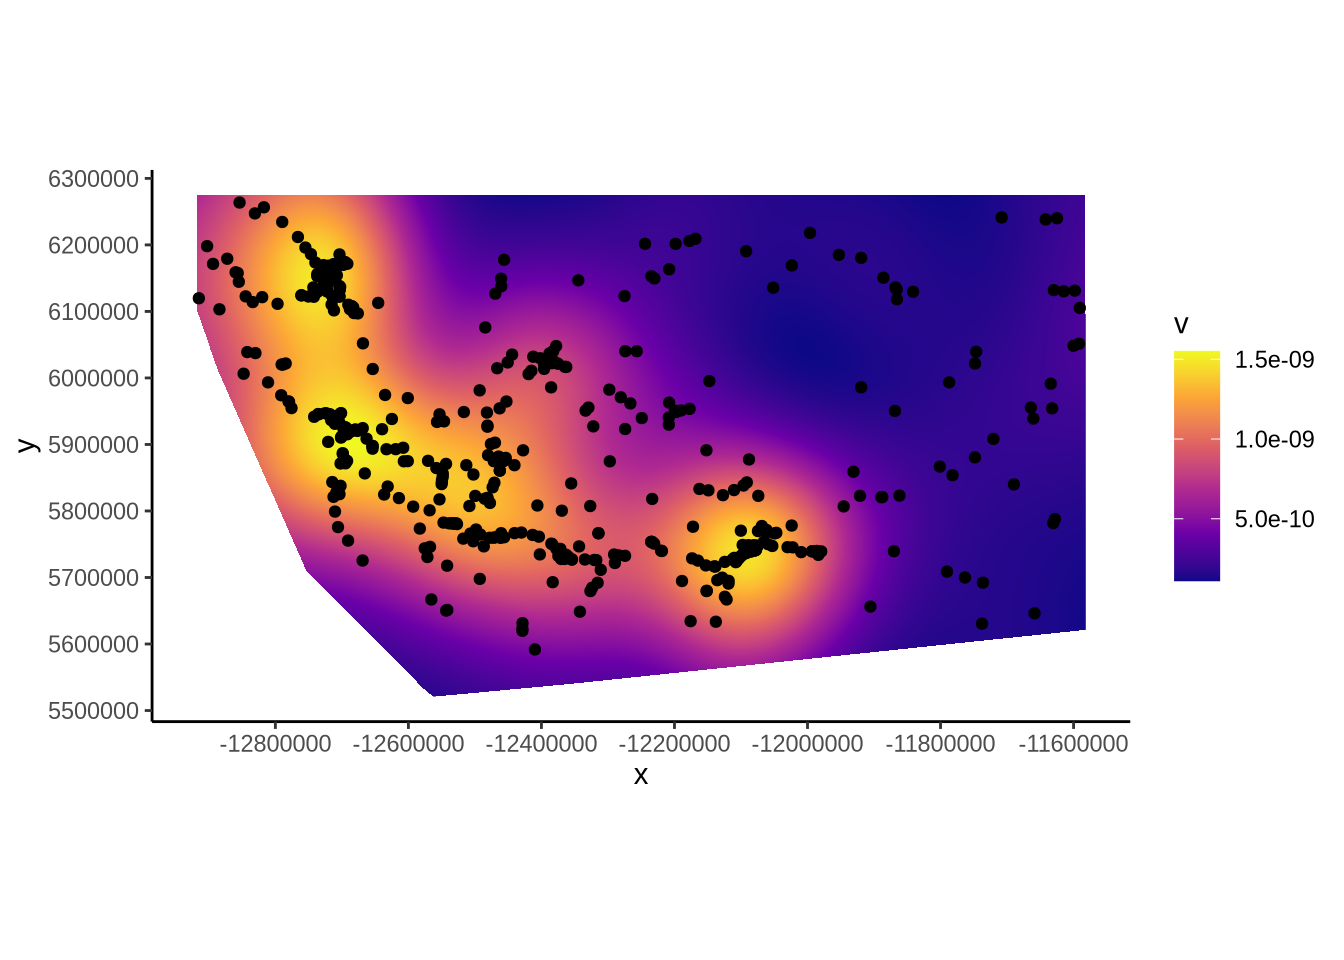

In [ ]:
pop_stars <- pop_int |> stars::st_as_stars()
nonrez_points_sf <- accidents_non_ppp |> sf::st_as_sf() |> filter(label == "point")
nonrez_points_sf |> ggplot() +
  stars::geom_stars(data=pop_stars) +
  geom_sf() +
  theme_classic() +
  scale_fill_viridis_c(option="C", na.value="transparent")

population data tesselation

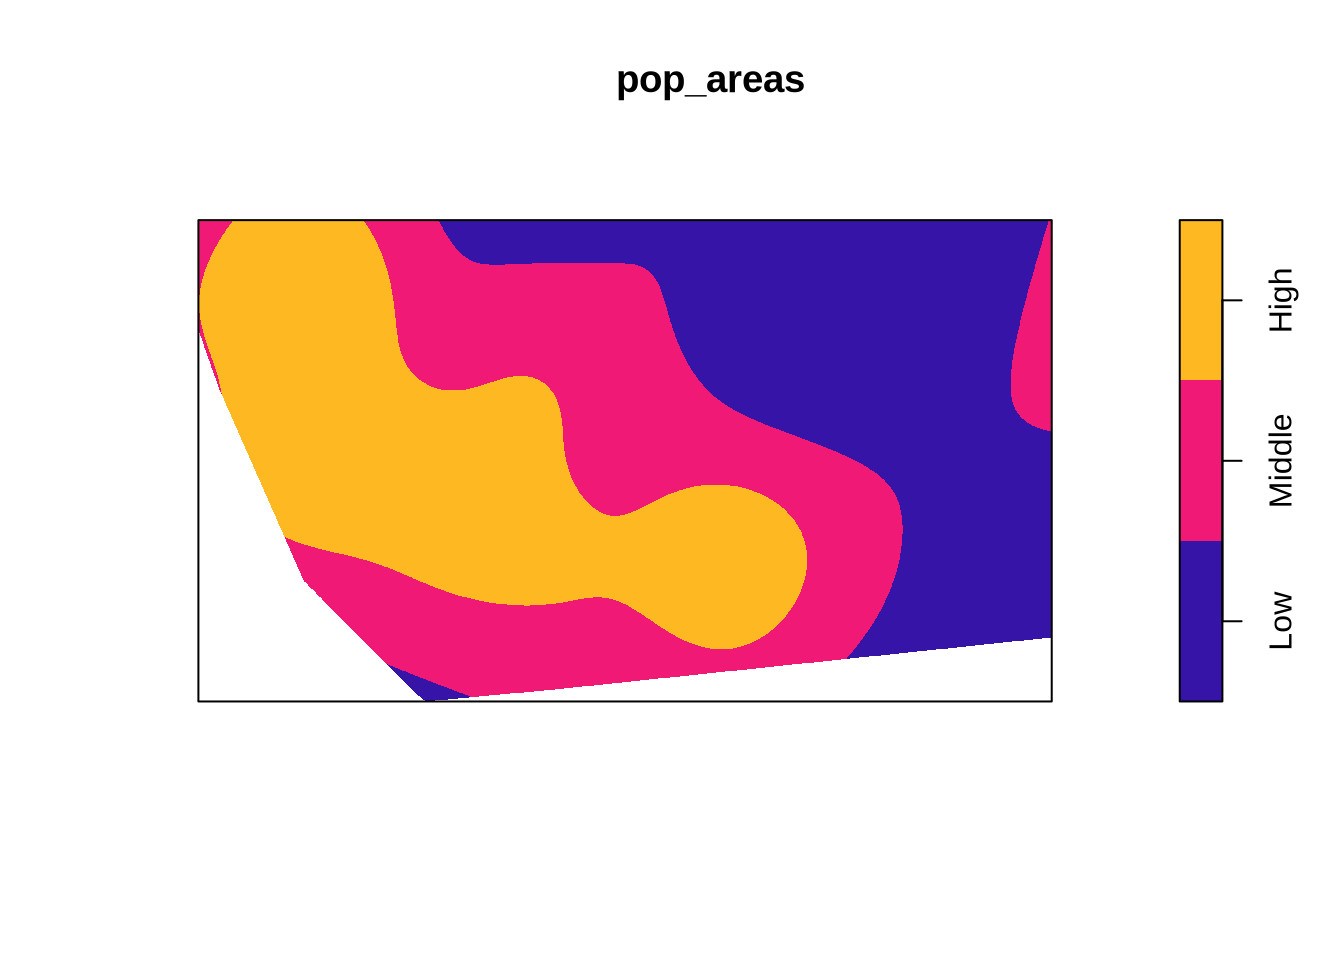

In [ ]:
num_regions <- 3
region_labels <- c("Low", "Middle", "High")
pop_vals <- pop_int
pop_quant <- quantile(pop_vals, probs=(0:num_regions) / num_regions, na.rm=TRUE)
pop_cut <- cut(pop_vals, breaks=pop_quant, labels=region_labels)
pop_areas <- tess(image=pop_cut)
plot(pop_areas)

rez accidents as point pattern

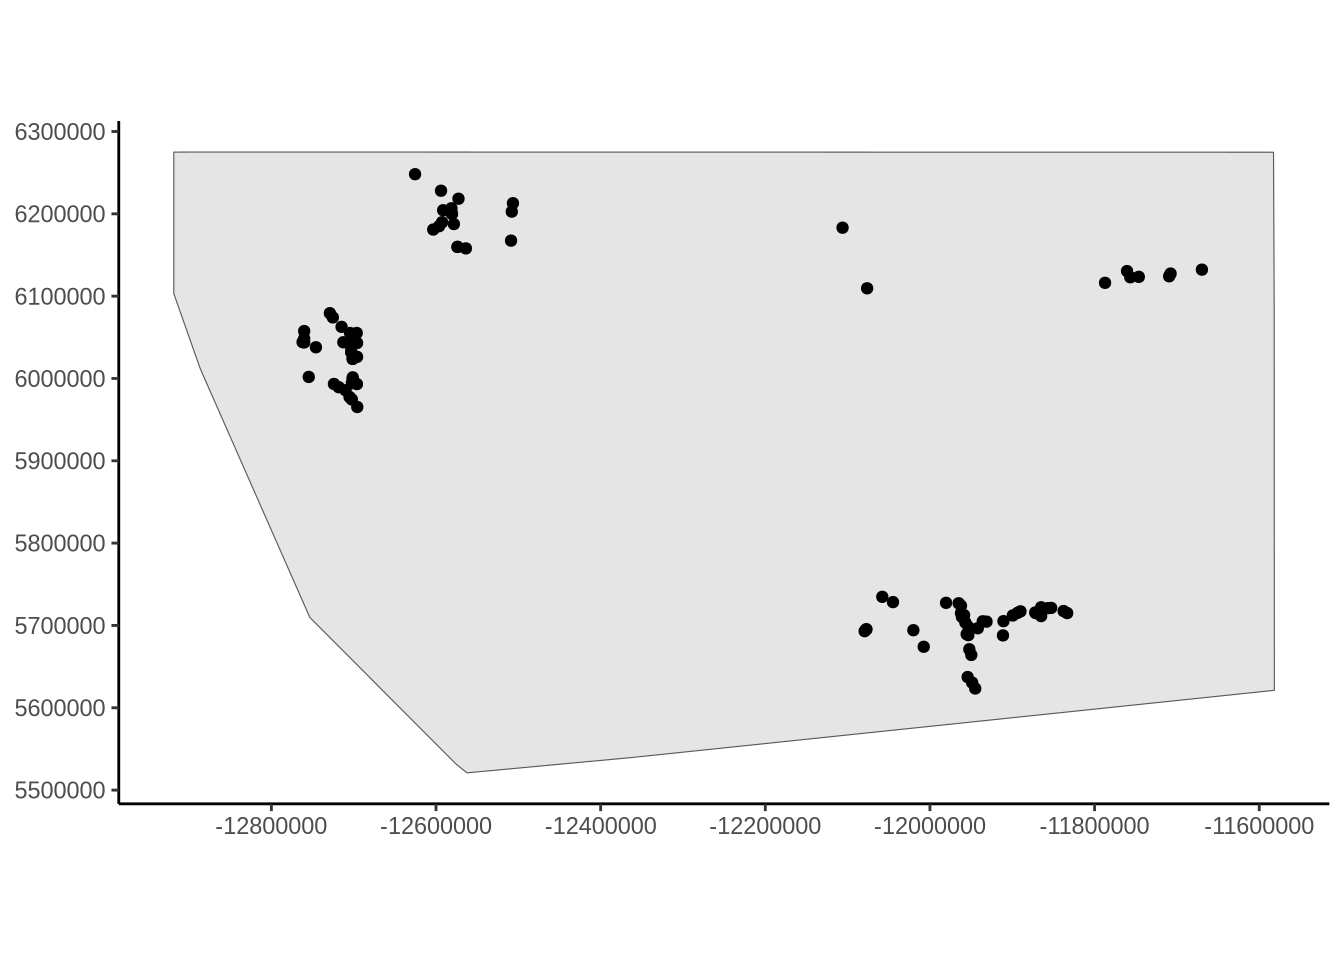

In [ ]:
accidents_rez_sfc <- accidents_sf |> filter(reservation==TRUE) |> sf::st_as_sfc()
accidents_rez_ppp <- as.ppp(accidents_rez_sfc, W=as.owin(mt_hull_sf))

accidents_rez_ppp |> sf::st_as_sf() |> ggplot() + 
    geom_sf() +
    theme_classic()

Reservation Intensity Function

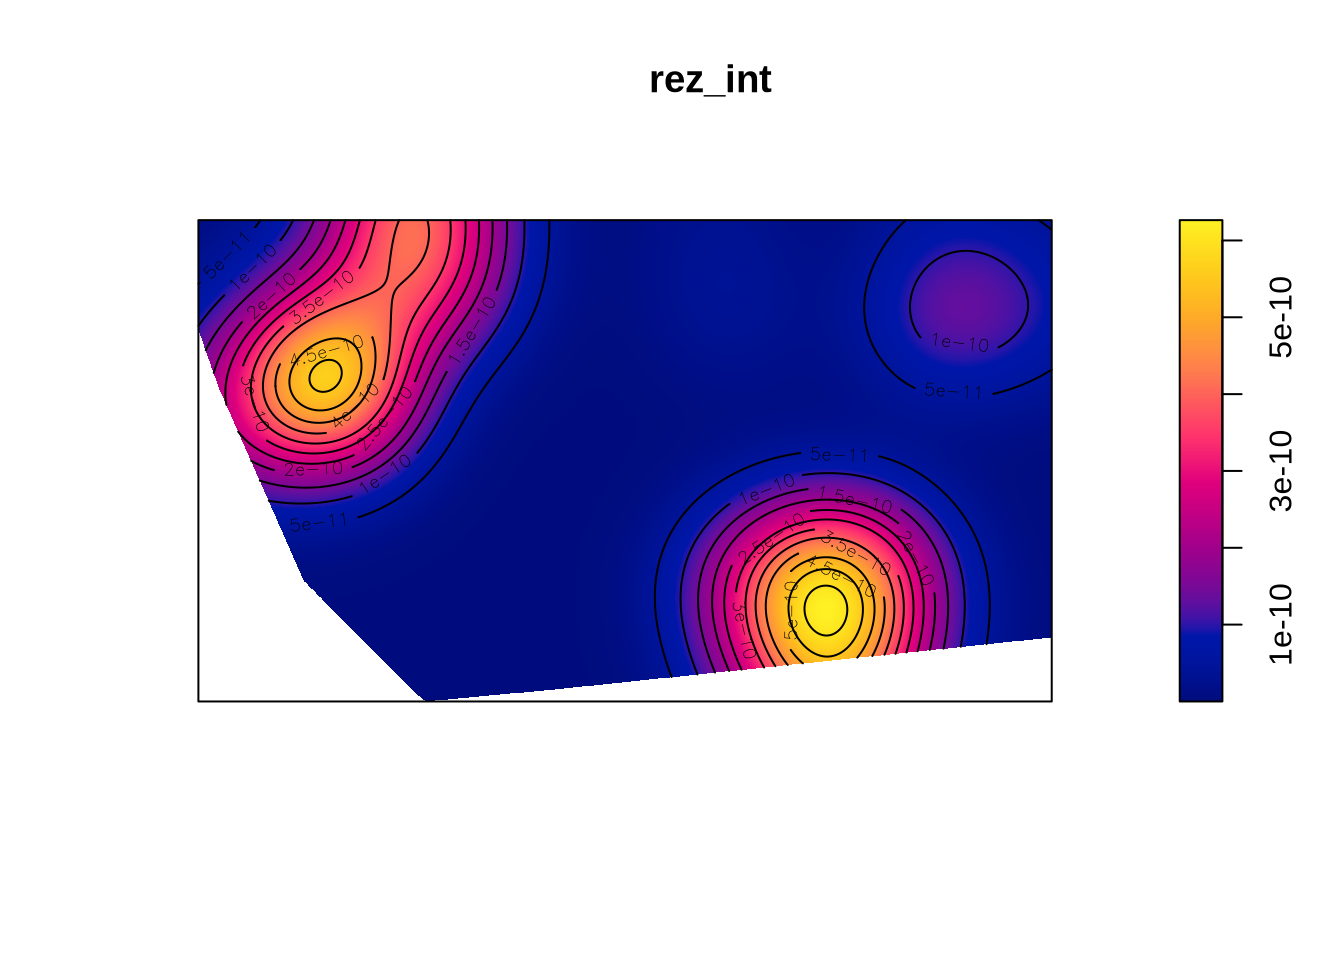

In [ ]:
rez_int <- density(accidents_rez_ppp, eps=raster_eps)

plot(rez_int)
contour(rez_int, add=TRUE)

low, medium, high poulation counts

In [ ]:
obs_rez_counts <- quadratcount(accidents_rez_ppp, tess=pop_areas) |> as.vector()
names(obs_rez_counts) <- region_labels
obs_rez_counts <- obs_rez_counts |> tibble::as_tibble_row()

Rez points on rez intensity function

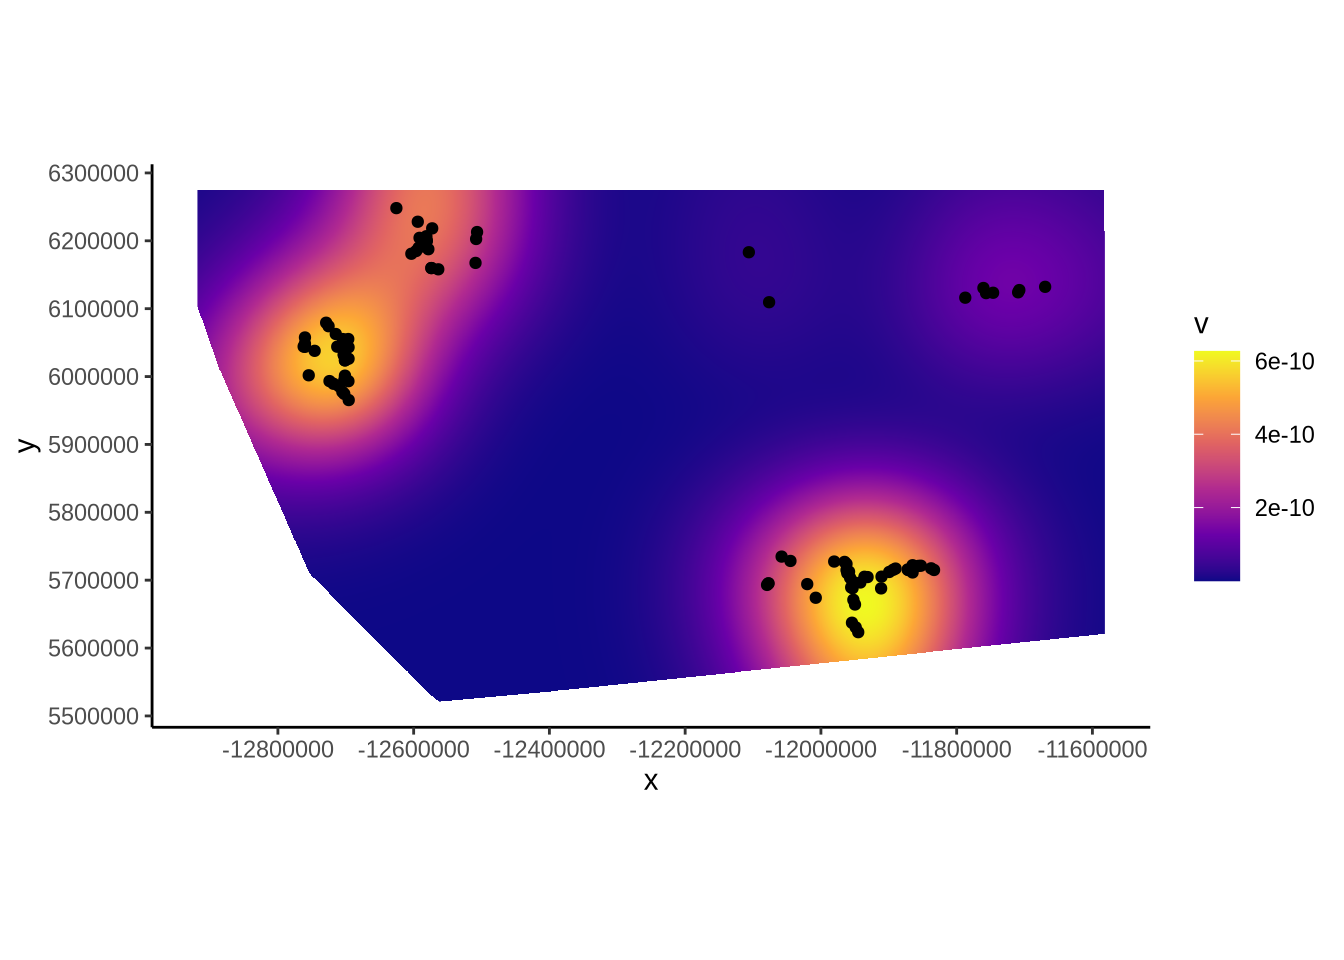

Saving 7 x 5 in image

In [ ]:
rez_stars <- rez_int |> stars::st_as_stars()
rez_points_sf <- accidents_rez_ppp |> sf::st_as_sf() |> filter(label == "point")
rez_points_sf |> ggplot() +
  stars::geom_stars(data=rez_stars) +
  geom_sf() +
  theme_classic() +
  scale_fill_viridis_c(option="C", na.value="transparent")

MOnte carlo simulation

In [ ]:
# Your code here
compute_quadrat_counts <- function(sim_ppp) {
  sim_counts <- quadratcount(sim_ppp, tess=pop_areas) |> as.vector()
  names(sim_counts) <- region_labels
  return(sim_counts)
}

gen_sims_ppp <- function(num_sims) {
  gen_sims <- spatstat.random::rpoint(
    n = nrow(rez_points_sf),
    f = pop_int,
    nsim = num_sims
  )
  return(gen_sims)
}
full_sims_list <- gen_sims_ppp(999)
full_count_list <- lapply(X = full_sims_list, FUN=compute_quadrat_counts)
full_count_df <- full_count_list |> as_tibble() |> t() |> as_tibble(.name_repair="unique")

New names:
• `` -> `...1`
• `` -> `...2`
• `` -> `...3`

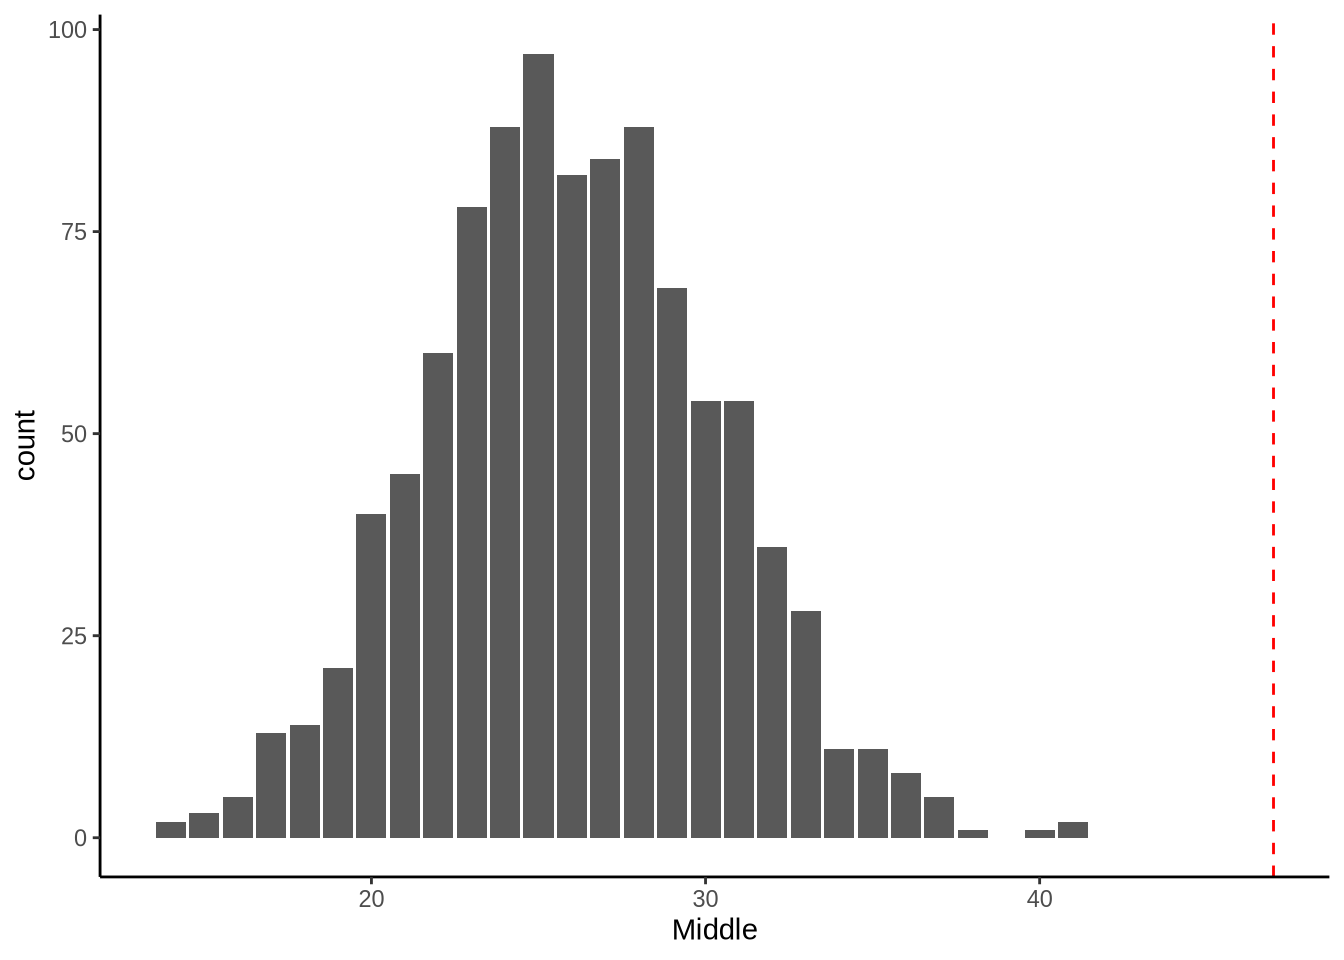

Saving 7 x 5 in image

In [ ]:
mc_df <- bind_rows(full_count_df, obs_rez_counts)
full_count_df |> ggplot(aes(x=Middle)) +
  geom_bar(stat='count') +
  geom_vline(xintercept = obs_rez_counts$Middle, linetype="dashed", color='red') +
  theme_classic()

## Discussion

## Conclusion

## References

Administration, National Highway Traffic Safety. 2020-2022. “Fatality Analysis Reporting System Data 2020-2022.” <https://www.nhtsa.gov/file-downloads?p=nhtsa/downloads/FARS/>.

Library, Administrative Boundaries Data Coordinator Montana State. 2021. “Tribal Nations in Montana.” <https://mslservices.mt.gov/geographic_information/data/datalist/datalist_Details.aspx?did=%7B341205DA-7668-4119-9D21-0D1C8AFCF5F1%7D>.

Pollack, K. M., S. Frattaroli, J. L. Young, G. Dana-Sacco, and A. C. Gielen. 2012. “Motor Vehicle Deaths Among American Indian and Alaska Native Populations.” *Epidemiologic Reviews* 34 (1): 73–88. <https://doi.org/10.1093/epirev/mxr019>.